# 1. IEEE - First Look and EDA

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.11.17 </div>
<div style="text-align: right\"> Last update: 2021.11.17</div>

- https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

데이터는 `identity`와 `transaction`으로 구분되어 있고 `TransactioID`로 구분된다.

#### Categorical Features - Transaction
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

#### Categorical Features - Identity
- DeviceType
- DeviceInfo
- id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

You can read more about the data from this post by the competition host.

데이터 관련 상세내용
- https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

파일들

- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
- sample_submission.csv - a sample submission file in the correct format

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [3]:
color_pal

['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']

In [5]:
sns.color_palette(color_pal)

[(0.8862745098039215, 0.2901960784313726, 0.2),
 (0.20392156862745098, 0.5411764705882353, 0.7411764705882353),
 (0.596078431372549, 0.5568627450980392, 0.8352941176470589),
 (0.4666666666666667, 0.4666666666666667, 0.4666666666666667),
 (0.984313725490196, 0.7568627450980392, 0.3686274509803922),
 (0.5568627450980392, 0.7294117647058823, 0.25882352941176473),
 (1.0, 0.7098039215686275, 0.7215686274509804)]

In [7]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:15])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216),
 (0.00784313725490196, 0.47058823529411764, 0.6823529411764706),
 (0.9529411764705882, 0.5725490196078431, 0.2),
 (0.6549019607843137, 0.7725490196078432, 0.9215686274509803),
 (0.32941176470588235, 0.8901960784313725, 0.27450980392156865),
 (0.6705882352941176, 0.807843137254902, 0.4549019607843137)]

## Data

In [8]:
train_transaction = pd.read_csv('./data/ieee-fraud-detection/train_transaction.csv')
test_transaction = pd.read_csv('./data/ieee-fraud-detection/test_transaction.csv')
# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('./data/ieee-fraud-detection/train_identity.csv')
test_identity = pd.read_csv('./data/ieee-fraud-detection/test_identity.csv')
# Sample Submissions
ss = pd.read_csv('./data/ieee-fraud-detection/sample_submission.csv')

In [9]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [10]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [11]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [140]:
test_identity.head()

TransactionID  id-01     id-02  id-03  id-04  id-05  id-06  id-07  id-08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id-09  ...                    id-31  id-32     id-33           id-34  \
0    NaN  ...  chrome 67.0 for android    NaN       NaN             NaN   
1    0.0  ...  chrome 67.0 for android   24.0  1280x720  match_status:2   
2    NaN  ...       ie 11.0 for tablet    NaN       NaN             NaN   
3    0.0  ...  chrome 67.0 for android    NaN       NaN             NaN   
4    NaN  ...  chrome 67.0 for android    NaN       NaN             NaN   

   id-35 id-36 id-37  id-38  DeviceType                   DeviceInfo  
0      F     F     T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
1      T     F     T      T      mobile         LGLS676 Build/MXB48T  
2      F     T     T      F     desktop                  Trident/7.0  
3      F     F     T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
4      F     F     T      F      mobile         SM-G9650 Build/R16NW  

[5 rows x 41 columns]

In [15]:
print(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique()).sum())
print(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique()).sum())

144233
141907


In [17]:
print(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique()).sum()/len(train_transaction))
print(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique()).sum()/len(test_transaction))

0.2442391709283029
0.28006615471756946


- 학습데이터에서 전체 TransactionID의 24.4프로 정도만 관련된 train_identity를 가지고 있다.

### Train vs Test are Time Series Split

In [18]:
train_transaction['TransactionDT']

0            86400
1            86401
2            86469
3            86499
4            86506
            ...   
590535    15811047
590536    15811049
590537    15811079
590538    15811088
590539    15811131
Name: TransactionDT, Length: 590540, dtype: int64

`TransactionDT`는 기준 시간대에서 거래가 이루어진 시점이다.   
이 기준으로 보면 학습 데이터는 과거 거래, 시험 데이터는 최신거래이다.

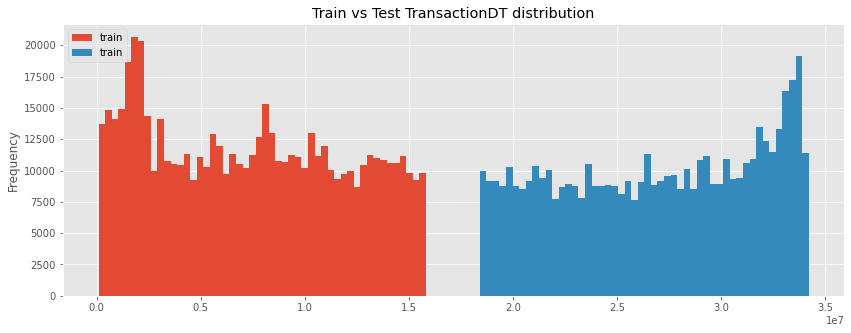

In [20]:
fig, ax = plt.subplots(figsize = (14, 5))
train_transaction['TransactionDT'].plot(kind = 'hist', label = 'train', bins = 50, ax = ax)
test_transaction['TransactionDT'].plot(kind = 'hist', label = 'train', bins = 50, ax = ax)

plt.title('Train vs Test TransactionDT distribution')
plt.legend()
plt.show()

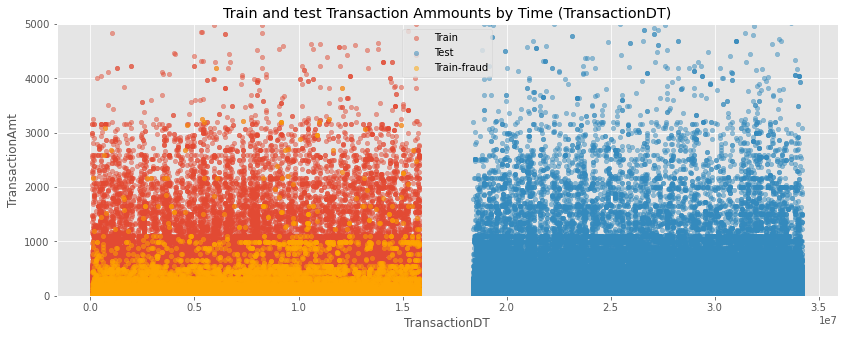

In [27]:
fig, ax = plt.subplots(figsize = (14, 5))
train_transaction.plot(kind = 'scatter', x = 'TransactionDT', y = 'TransactionAmt', color=color_pal[0],
                       alpha = 0.5, label= 'Train', ax = ax)
test_transaction.plot(kind = 'scatter', x = 'TransactionDT', y = 'TransactionAmt', color=color_pal[1],
                       alpha = 0.5, label= 'Test', ax = ax)

train_transaction.loc[train_transaction['isFraud'] == 1]\
                .plot(kind = 'scatter', x = 'TransactionDT', y = 'TransactionAmt', color='orange',
                       alpha = 0.5, label= 'Train-fraud', ax = ax)

plt.title('Train and test Transaction Ammounts by Time (TransactionDT)')
plt.ylim([0, 5000])
plt.legend()
plt.show()

### Target 분포

In [31]:
train_transaction['isFraud'].value_counts()/len(train_transaction)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

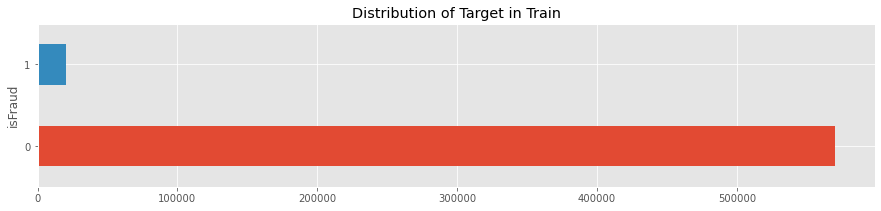

In [37]:
train_transaction.groupby('isFraud').count()['TransactionID'].plot(kind='barh',
          title='Distribution of Target in Train', color= color_pal,
          figsize=(15, 3))
plt.show()

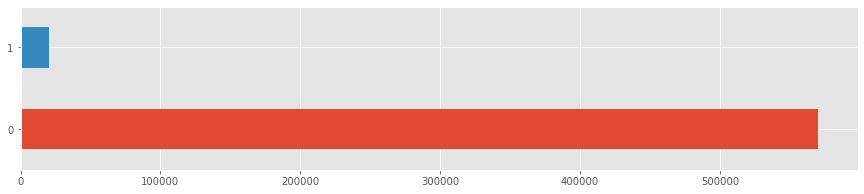

In [40]:
train_transaction['isFraud'].value_counts().plot(kind = 'barh', color = color_pal, figsize = (15, 3))
plt.show()

### TransactionAmt

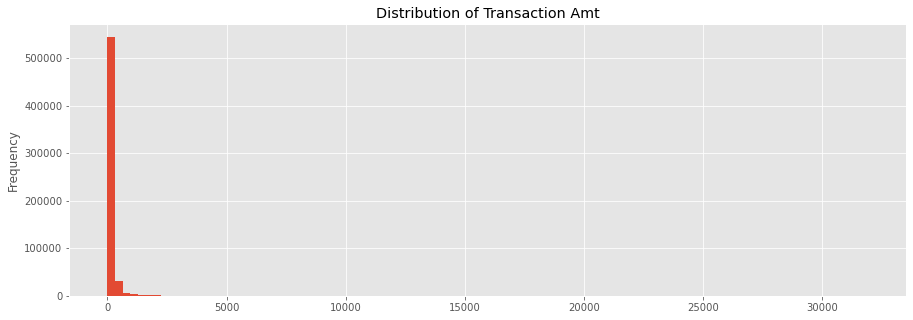

In [43]:
train_transaction['TransactionAmt'].plot(kind= 'hist', bins = 100, figsize = (15, 5), 
                                        title='Distribution of Transaction Amt')
plt.show()

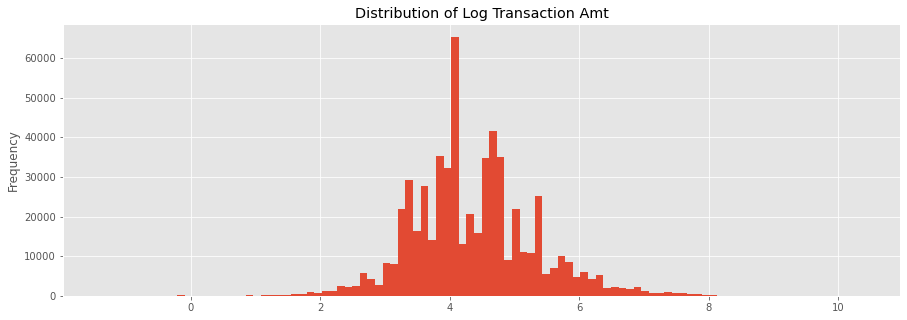

In [42]:
train_transaction['TransactionAmt'].apply(np.log).plot(kind= 'hist', bins = 100, figsize = (15, 5), 
                                        title='Distribution of Log Transaction Amt')
plt.show()

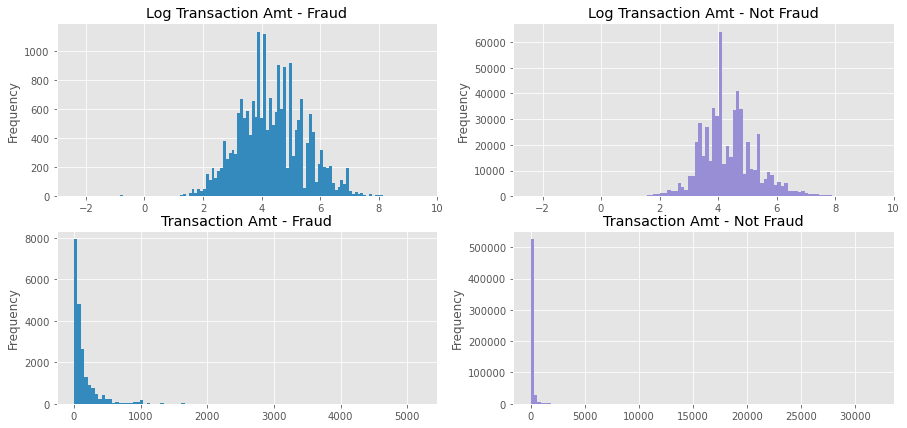

In [47]:
fig, axes = plt.subplots(2, 2, figsize = (15, 7))

train_transaction[train_transaction['isFraud']==1]['TransactionAmt'].apply(np.log).\
        plot(kind= 'hist', bins = 100, title = 'Log Transaction Amt - Fraud',
          color=color_pal[1], xlim=(-3, 10), ax= axes[0][0])
train_transaction[train_transaction['isFraud']==0]['TransactionAmt'].apply(np.log).\
        plot(kind= 'hist', bins = 100, title = 'Log Transaction Amt - Not Fraud',
          color=color_pal[2], xlim=(-3, 10), ax= axes[0][1])

train_transaction[train_transaction['isFraud']==1]['TransactionAmt'].\
        plot(kind= 'hist', bins = 100, title = 'Transaction Amt - Fraud',
          color=color_pal[1], ax= axes[1][0])
train_transaction[train_transaction['isFraud']==0]['TransactionAmt'].\
        plot(kind= 'hist', bins = 100, title = 'Transaction Amt - Not Fraud',
          color=color_pal[2], ax= axes[1][1])

plt.show()

In [48]:
print('Mean transaction amt for fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


### ProductCD

- 의미하는 바를 모른다.  

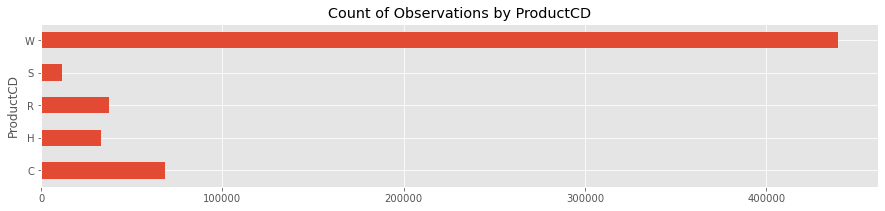

In [49]:
train_transaction.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

<AxesSubplot:title={'center':'Count of Observations by ProductCD'}>

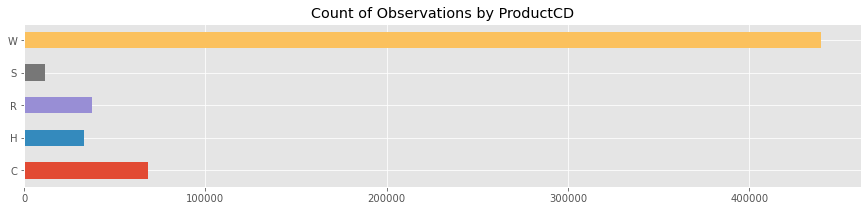

In [51]:
train_transaction['ProductCD'].value_counts().sort_index().plot(kind = 'barh', 
                                        figsize = (15, 3), title='Count of Observations by ProductCD',
                                                  color = color_pal)

각 카테고리별 fraud의 비율을 살펴보자.

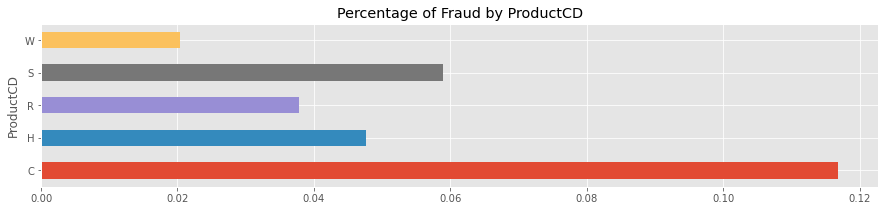

In [53]:
train_transaction.groupby('ProductCD')['isFraud'].mean().sort_index().plot(kind = 'barh', figsize = (15, 3),
                                                                          title = 'Percentage of Fraud by ProductCD',
                                                                          color = color_pal)
plt.show()

### Categorical Features - Transaction  
다음 컬럼이 카테고리이다.   
- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

In [56]:
len(train_transaction.columns)

394

#### card1 ~ 6

In [57]:
card_cols = [c for c in train_transaction.columns if 'card' in c]

In [58]:
train_transaction[card_cols].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

In [59]:
train_transaction[card_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int64  
 1   card2   581607 non-null  float64
 2   card3   588975 non-null  float64
 3   card4   588963 non-null  object 
 4   card5   586281 non-null  float64
 5   card6   588969 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 27.0+ MB


card1, 2, 3, 5 는 실수형이다.  
실수형에 대해서 만 분포를 그려보자.

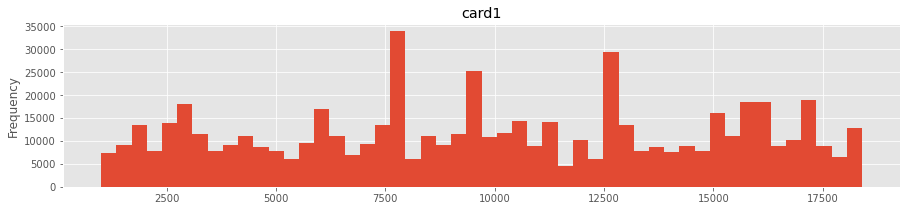

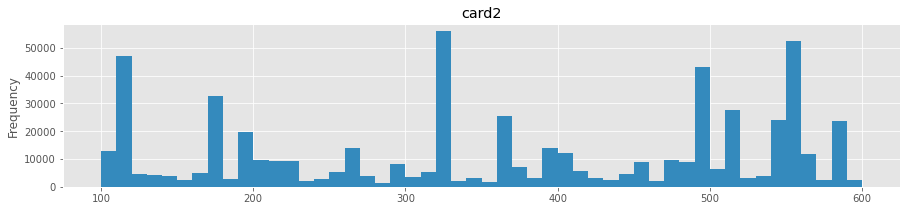

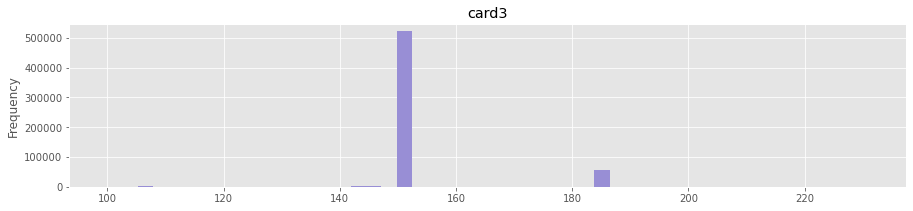

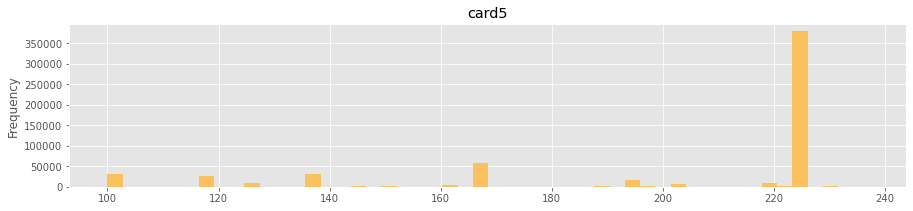

In [60]:
for i, col in enumerate(card_cols):
    if train_transaction[col].dtype in ['float64', 'int64']:
        train_transaction[col].plot(kind = 'hist', title = col, bins = 50, figsize = (15, 3),
                                   color = color_pal[i])
    plt.show()

카테고리 컬럼에 card4, 5에 대한 분포확인

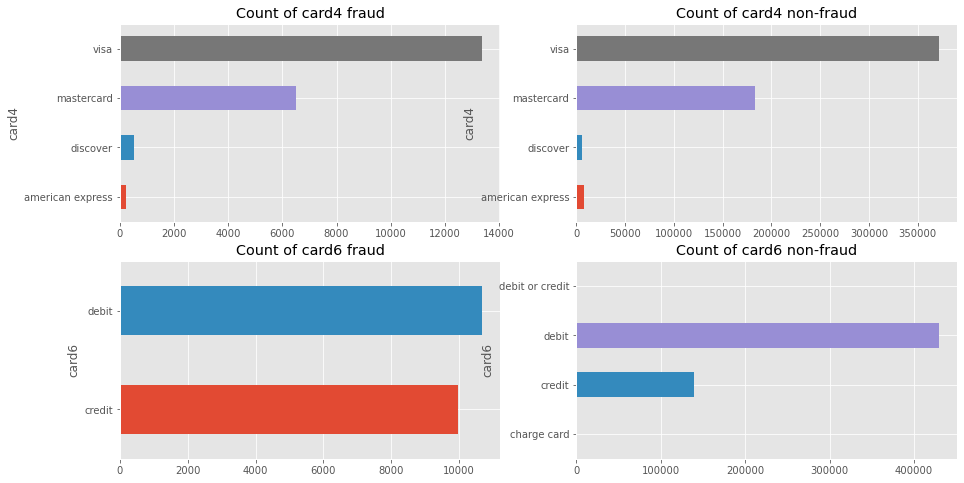

In [62]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud', 
                                                            color = color_pal)
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud',
                                                             color = color_pal)
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud', 
                                                           color = color_pal)
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud',
                                                             color = color_pal)
plt.show()

#### addr1, 2

In [63]:
train_transaction[['addr1', 'addr2']].head()

addr1  addr2
0  315.0   87.0
1  325.0   87.0
2  330.0   87.0
3  476.0   87.0
4  420.0   87.0

In [64]:
train_transaction[['addr1', 'addr2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   addr1   524834 non-null  float64
 1   addr2   524834 non-null  float64
dtypes: float64(2)
memory usage: 9.0 MB


In [65]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


- 결측치가 존재

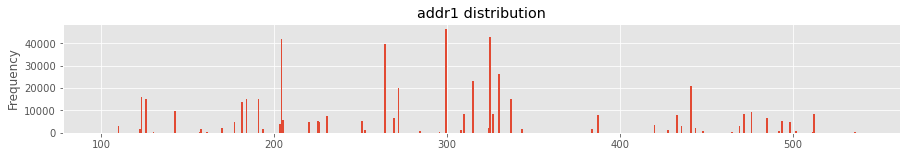

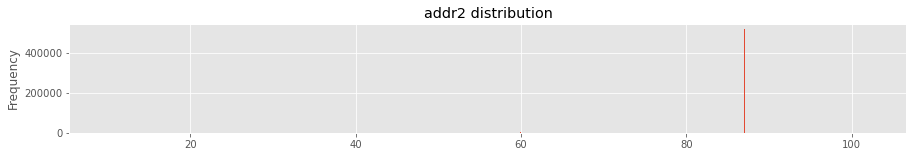

In [67]:
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

#### dist1, 2
카드 사용지와 집까지의 거리

In [68]:
train_transaction[['dist1', 'dist2']].head()

dist1  dist2
0   19.0    NaN
1    NaN    NaN
2  287.0    NaN
3    NaN    NaN
4    NaN    NaN

In [69]:
train_transaction[['dist1', 'dist2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dist1   238269 non-null  float64
 1   dist2   37627 non-null   float64
dtypes: float64(2)
memory usage: 9.0 MB


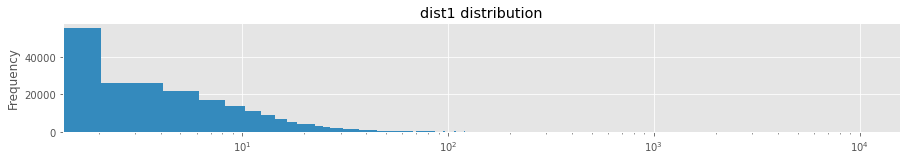

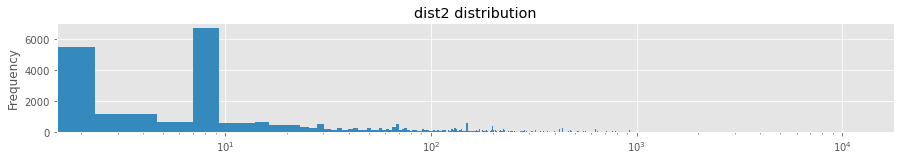

In [70]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

- 로그를 취하는 것이 더 좋아 보인다.  
로그 처리한 결과

In [71]:
train_transaction['dist1'].apply(np.log).plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].apply(np.log).plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

ValueError: autodetected range of [-inf, 9.23853902633486] is not finite

- 결측치 때무에 안됨

0 때문에 log대시 log 1p를 써야함

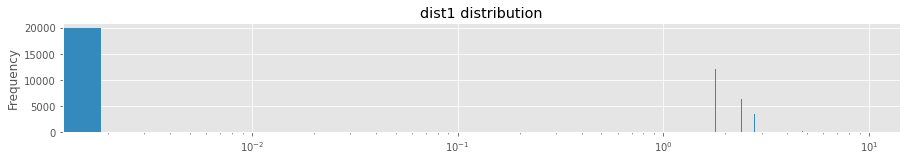

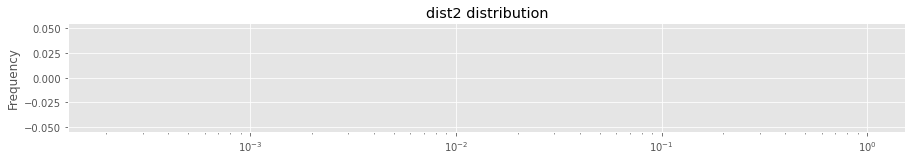

In [76]:
train_transaction[train_transaction['dist1'].notnull()]['dist1'].apply(np.log1p).plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

train_transaction[train_transaction['dist2'].notnull()]['dist1'].apply(np.log1p).plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

#### C1 ~ 14

실수형 데이터에 대해서는 pairplot을 그려볼 수 있다.   
피처간 상관성을 이해하는데 좋다.

In [77]:
c_cols = [c for c in train_transaction if c[0] == 'C']

In [79]:
print(c_cols)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


In [80]:
c_cols = [c for c in train_transaction.columns if c[0] == 'C']

In [82]:
print(c_cols)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


In [84]:
train_transaction[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

정상, 비정상 샘플 각 500개씩만 샘플링하여 pair plot을 그려보자.

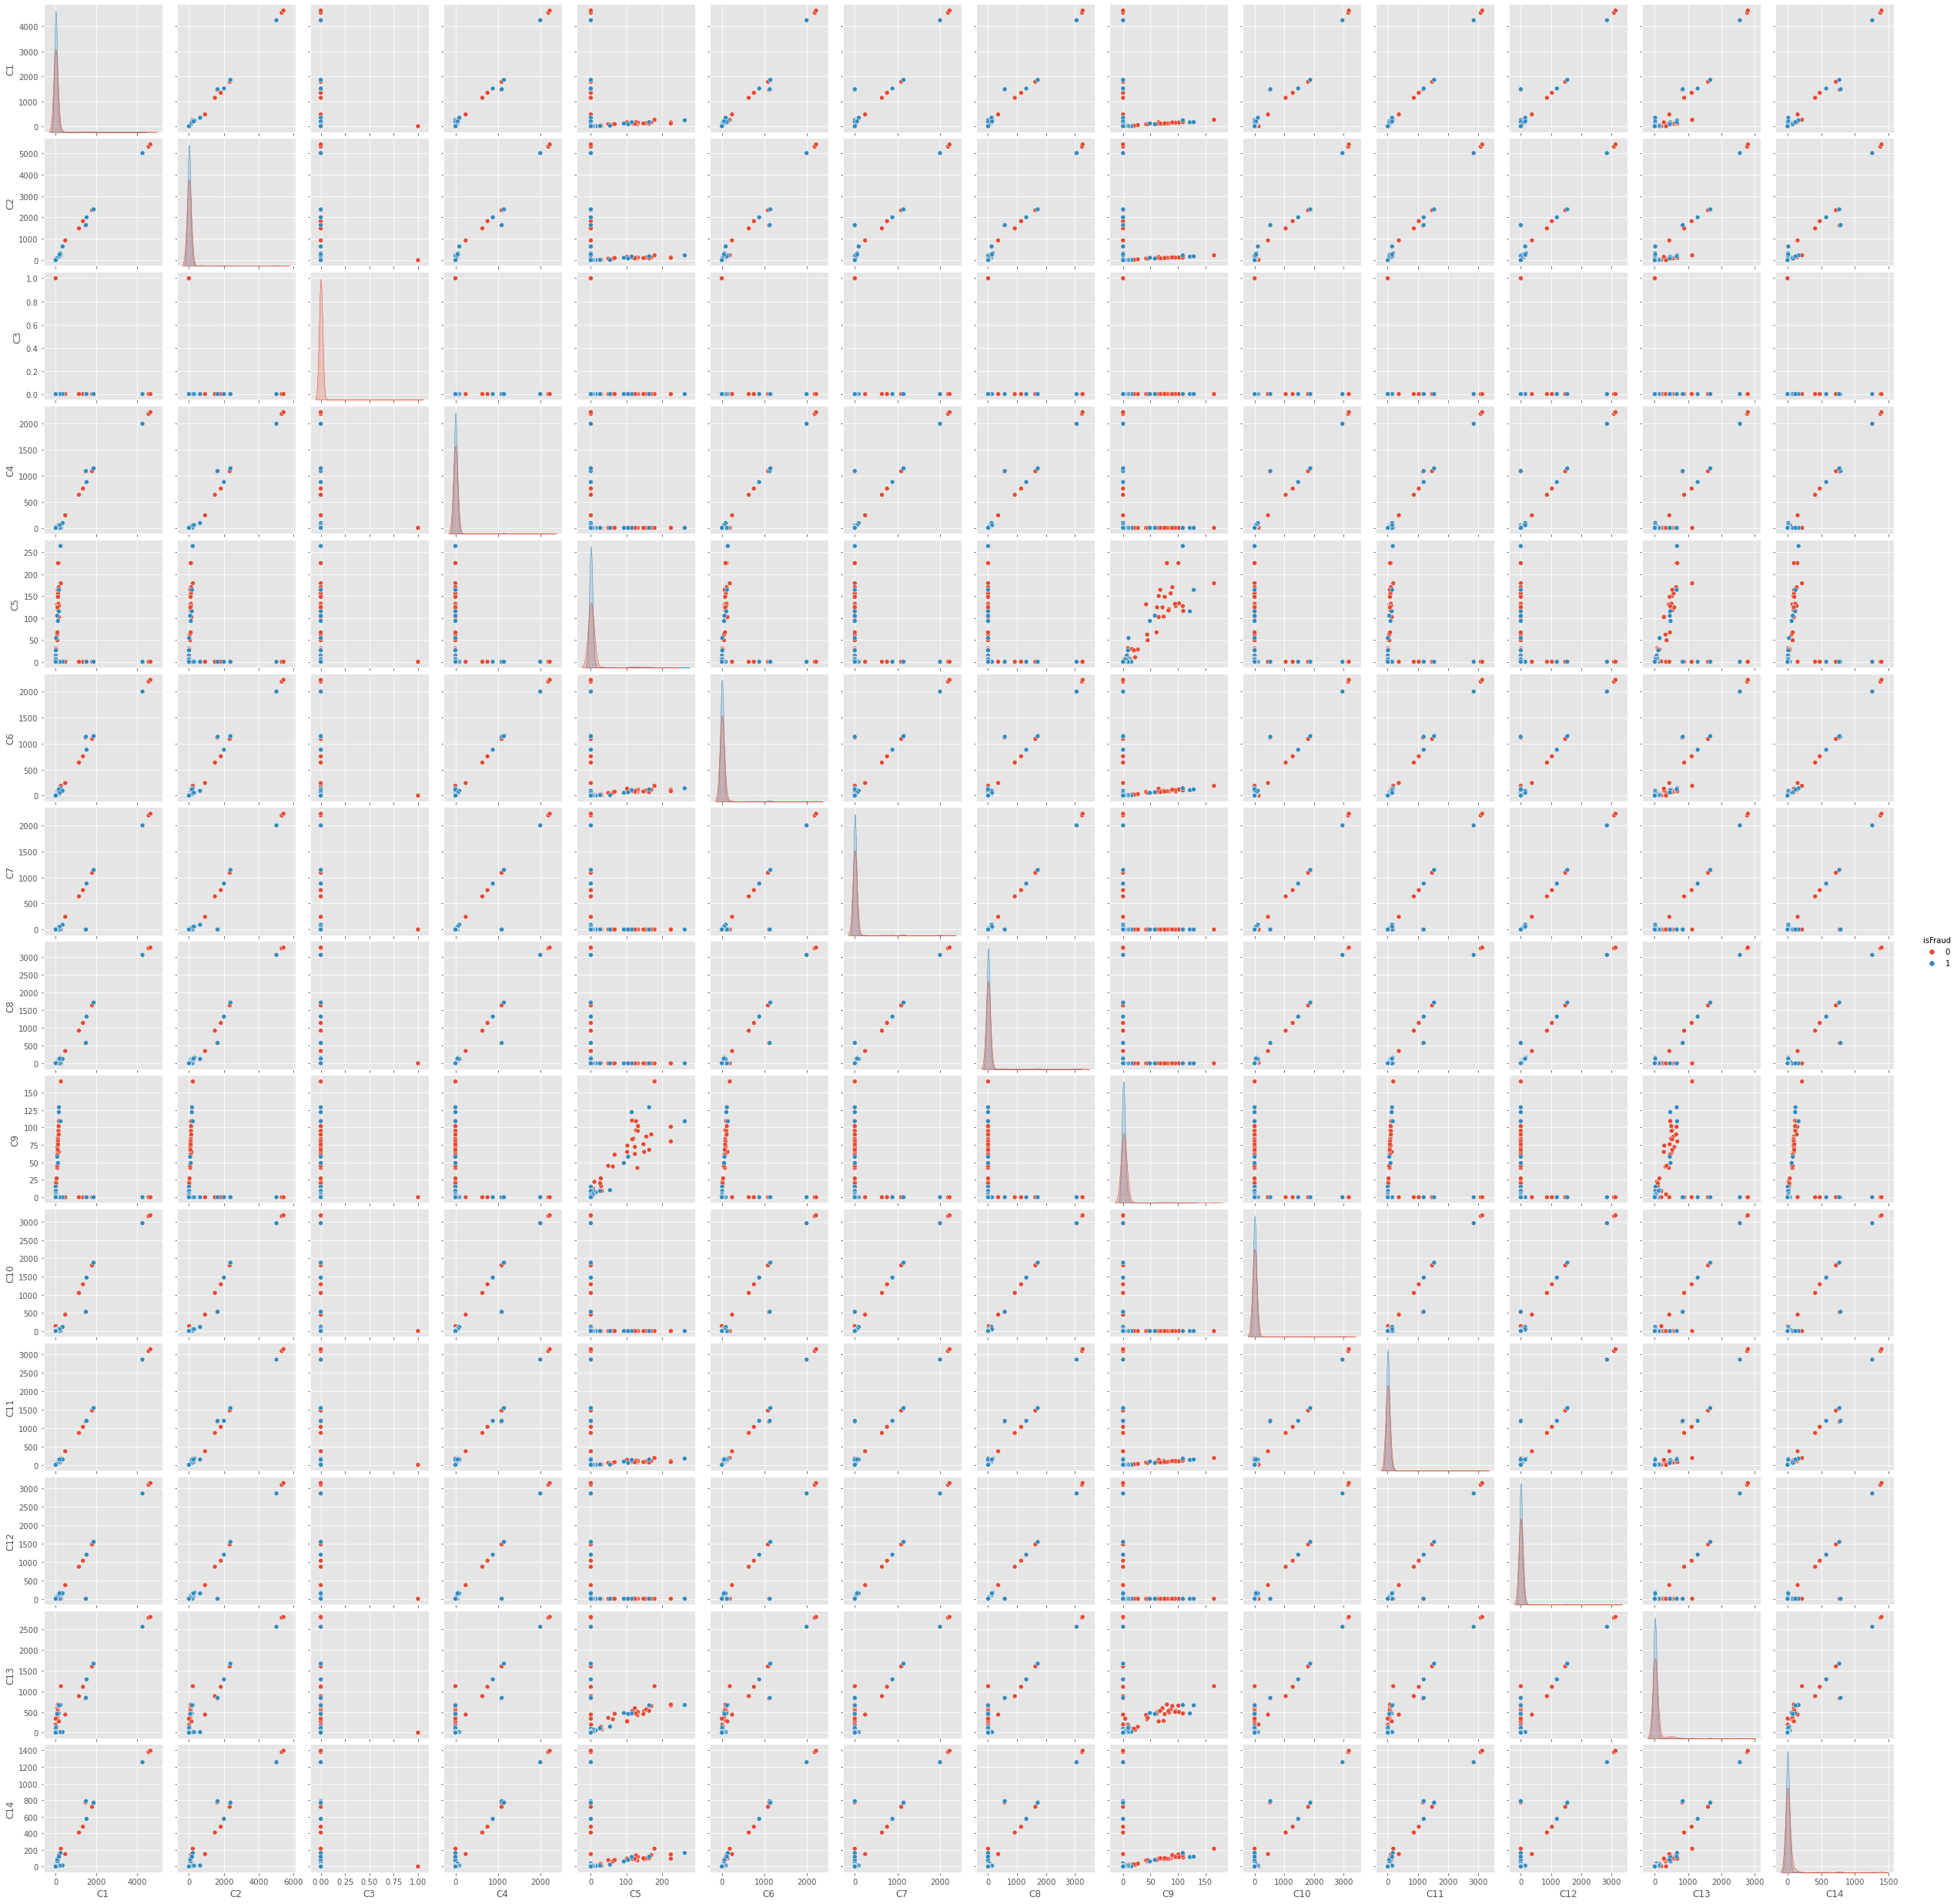

In [85]:
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, hue='isFraud',vars=c_cols)
plt.show()

#### D1 ~ 9

앞과 비슷하게 그려본다.

In [86]:
d_cols = [c for c in train_transaction.columns if c[0] == 'D']

In [88]:
print(d_cols)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']


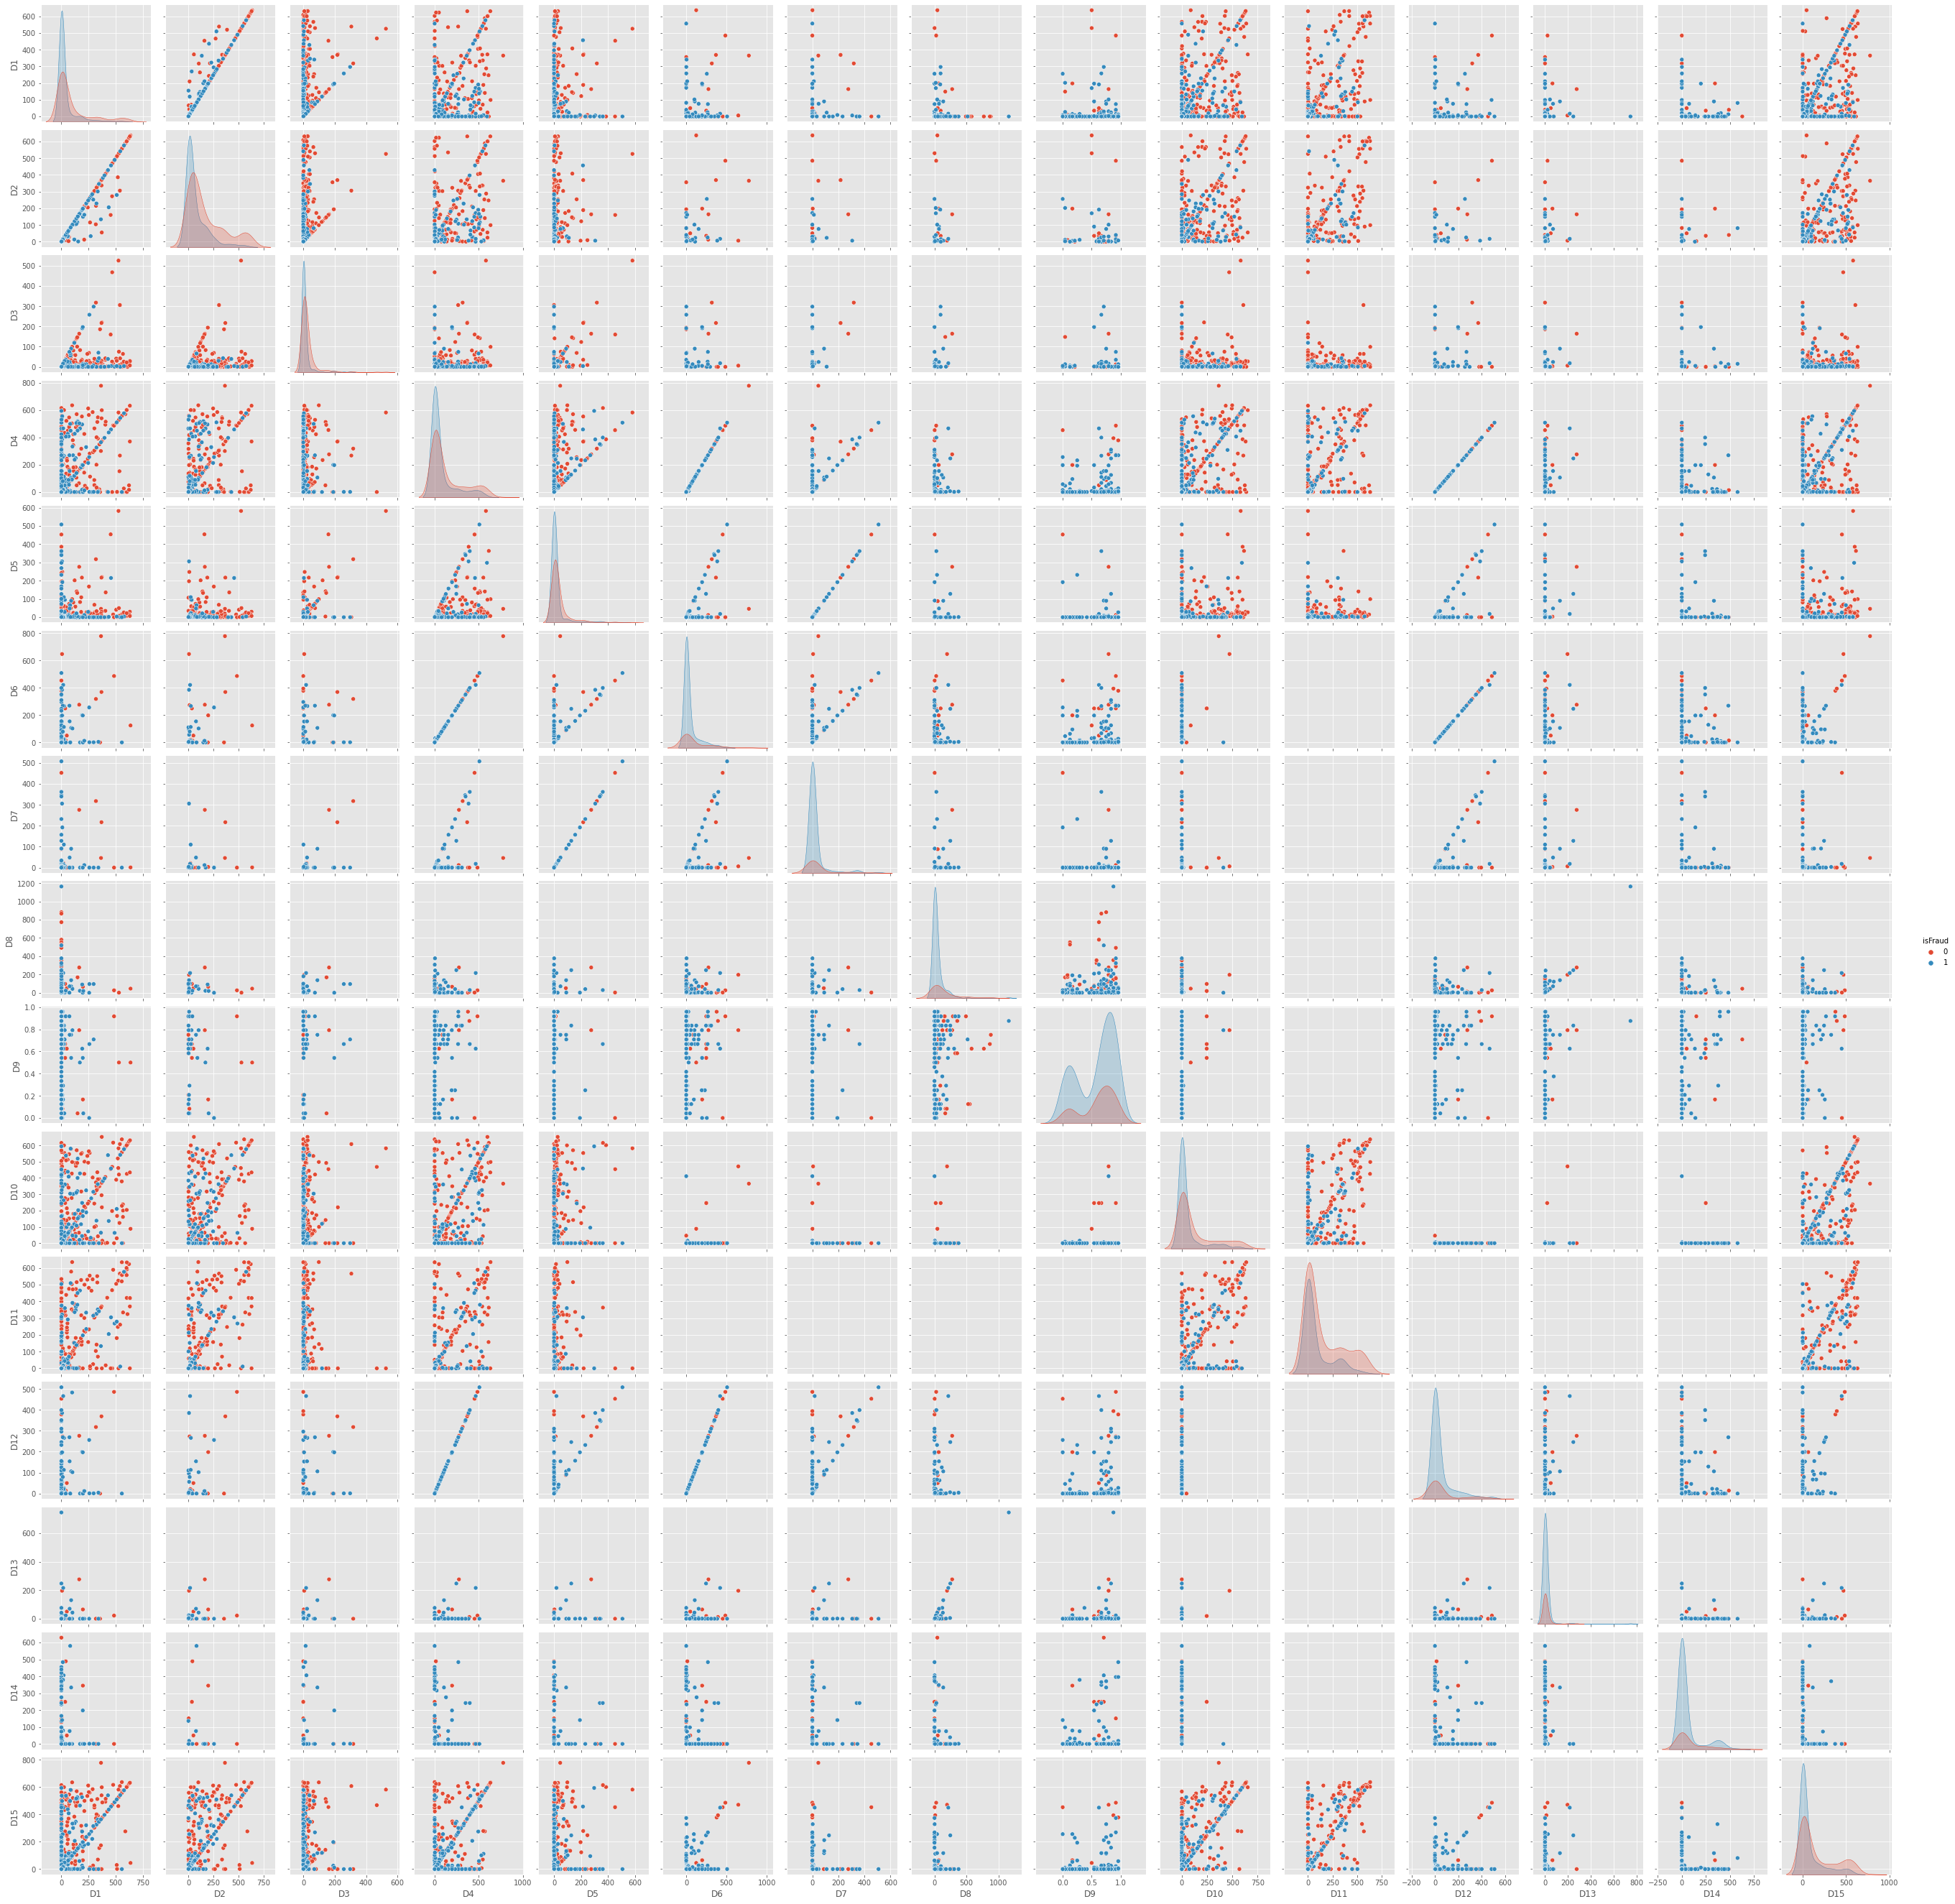

In [89]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

#### M1 ~ 9

- T, F, 또는 NaN 중에 하나인 값이다.  
- 단 M4는 다른 값을 가진다.

In [98]:
for i in range(len(m_cols)):
    print('column name : {}'.format(m_cols[i]))
    print(train_transaction[m_cols[i]].value_counts())

column name : M1
T    319415
F        25
Name: M1, dtype: int64
column name : M2
T    285468
F     33972
Name: M2, dtype: int64
column name : M3
T    251731
F     67709
Name: M3, dtype: int64
column name : M4
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
column name : M5
F    132491
T    107567
Name: M5, dtype: int64
column name : M6
F    227856
T    193324
Name: M6, dtype: int64
column name : M7
F    211374
T     32901
Name: M7, dtype: int64
column name : M8
F    155251
T     89037
Name: M8, dtype: int64
column name : M9
T    205656
F     38632
Name: M9, dtype: int64


In [90]:
m_cols = [c for c in train_transaction.columns if c[0] =='M']

In [91]:
train_transaction[m_cols].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

각 컬럼의 T, F, Nan 갯수를 확인해보자.

In [99]:
train_transaction[m_cols] == 'T'

M1     M2     M3     M4     M5     M6     M7     M8     M9
0        True   True   True  False  False   True  False  False  False
1       False  False  False  False   True   True  False  False  False
2        True   True   True  False  False  False  False  False  False
3       False  False  False  False   True  False  False  False  False
4       False  False  False  False  False  False  False  False  False
...       ...    ...    ...    ...    ...    ...    ...    ...    ...
590535   True   True   True  False   True  False  False  False   True
590536   True  False  False  False  False   True  False  False  False
590537   True  False  False  False  False   True  False  False  False
590538   True   True   True  False  False   True  False  False  False
590539   True  False  False  False  False   True  False  False  False

[590540 rows x 9 columns]

In [100]:
(train_transaction[m_cols] == 'T').sum()

M1    319415
M2    285468
M3    251731
M4         0
M5    107567
M6    193324
M7     32901
M8     89037
M9    205656
dtype: int64

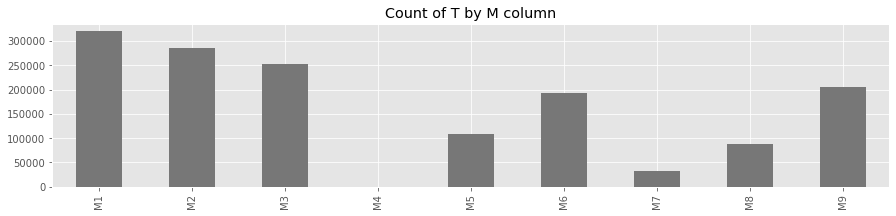

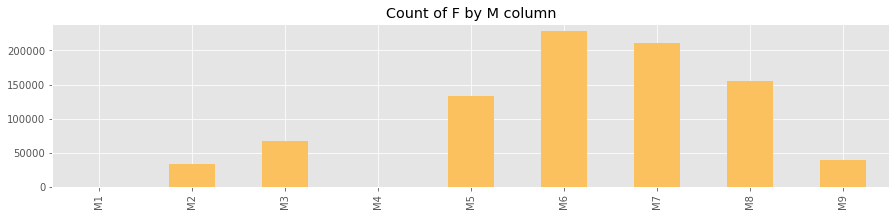

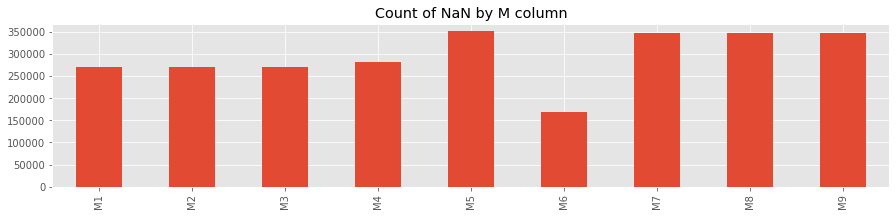

In [102]:
(train_transaction[m_cols] == 'T').sum().plot(kind = 'bar', title = 'Count of T by M column', 
                                              figsize = (15, 3), color = color_pal[3])
plt.show()
(train_transaction[m_cols] == 'F').sum().plot(kind = 'bar', title = 'Count of F by M column', 
                                              figsize = (15, 3), color = color_pal[4])
plt.show()
(train_transaction[m_cols].isna()).sum().plot(kind = 'bar', title = 'Count of NaN by M column',
                                             figsize = (15, 3), color = color_pal[0])
plt.show()

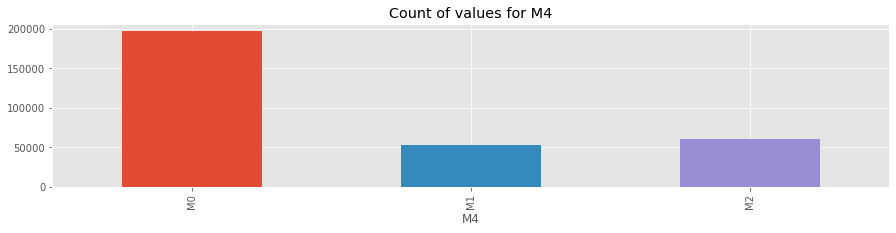

In [105]:
# Looking at M4 column since it is different than the others
train_transaction.groupby('M4')['TransactionID'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M4', color = color_pal,
          figsize=(15, 3))
plt.show()

#### V1 ~ 339
대부분이 0, 1, nan으로 되어있고 일부 큰 값이 있다.

In [106]:
v_cols = [c for c in train_transaction.columns if c[0] == 'V']

In [107]:
train_transaction[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

In [108]:
train_transaction[v_cols].describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311253.000000  311253.000000  ...  82351.000000   82351.000000   
mean        1.041529       0.463915  ...      0.775874     721.741883   
std         0.226339       0.521522  ...      4.727971    6217.223583   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

In [109]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

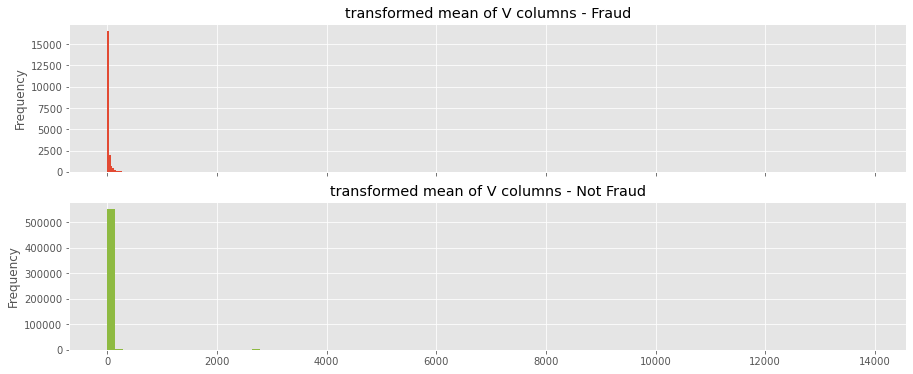

In [114]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15, 6))
train_transaction.loc[train_transaction['isFraud']==1]['v_mean'].plot(kind = 'hist', bins = 100, 
                                                                title = 'transformed mean of V columns - Fraud', ax = ax1)
train_transaction.loc[train_transaction['isFraud']==0]['v_mean'].plot(kind = 'hist', bins = 100, 
                                                                title = 'transformed mean of V columns - Not Fraud', ax = ax2,
                                                                     color = color_pal[5])
plt.show()

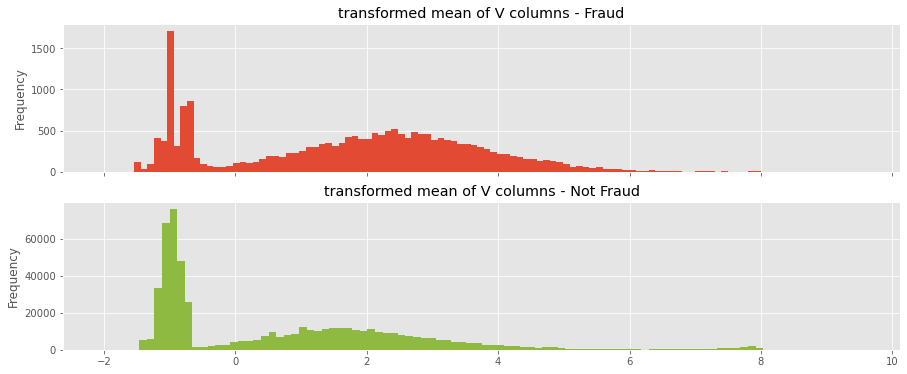

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15, 6))
train_transaction.loc[train_transaction['isFraud']==1]['v_mean'].apply(np.log).plot(kind = 'hist', bins = 100, 
                                                                title = 'transformed mean of V columns - Fraud', ax = ax1)
train_transaction.loc[train_transaction['isFraud']==0]['v_mean'].apply(np.log).plot(kind = 'hist', bins = 100, 
                                                                title = 'transformed mean of V columns - Not Fraud', ax = ax2,
                                                                     color = color_pal[5])
plt.show()

### Identity Data

In [118]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

- 제공된 transaction ID는 일부이다. 고객의 신상정보를 담고 있다.

거래정보의 `TransactinoDT`와 `isFraud` 컬럼을 병합하자.

In [122]:
train_identity_ = train_identity.merge(train_transaction[['TransactionID', 'TransactionDT', 'isFraud']], 
                                       on = ['TransactionID'])

test_identity_ = test_identity.merge(test_transaction[['TransactionID', 'TransactionDT']], 
                                       on = ['TransactionID'])

#### DeviceType

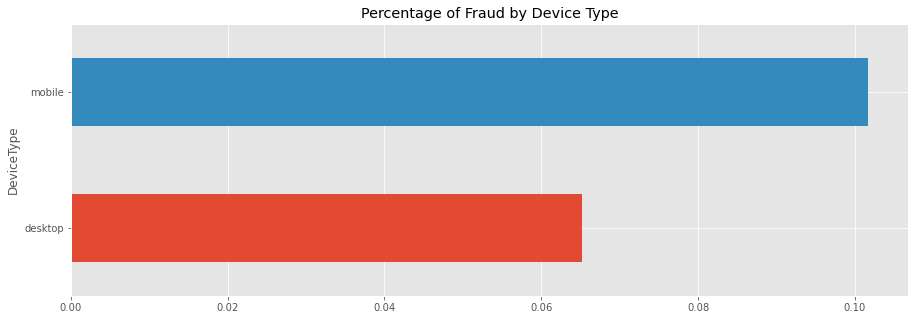

In [124]:
train_identity_.groupby('DeviceType')['isFraud'].mean().sort_values().plot(kind = 'barh', figsize = (15, 5), color=color_pal,
                                                                          title='Percentage of Fraud by Device Type')
plt.show()

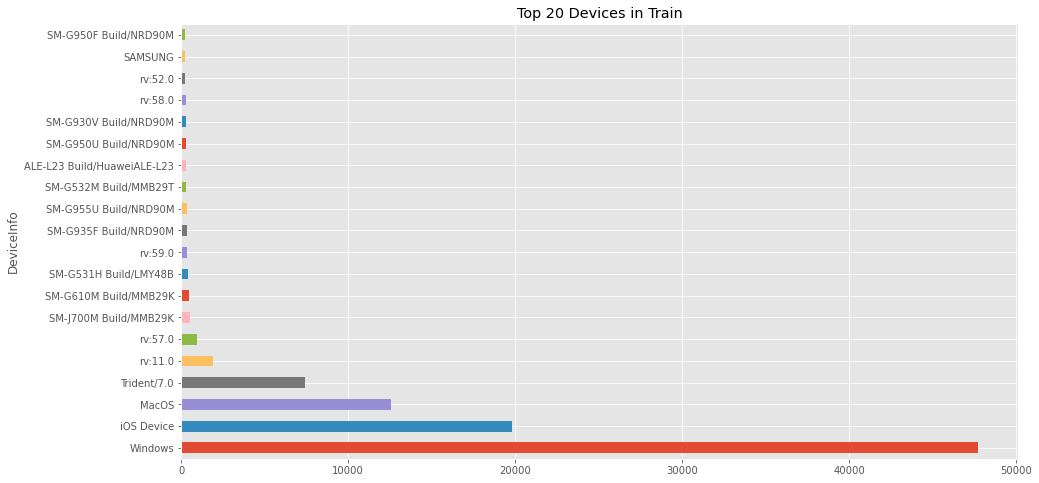

In [126]:
train_identity_.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 8), color = color_pal, title='Top 20 Devices in Train')
plt.show()

#### 시간에 따른 id 컬럼의 값들

In [127]:
id_cols = [c for c in train_identity.columns if 'id' in c]

In [128]:
print(id_cols)

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [133]:
test_identity_.columns

Index(['TransactionID', 'id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06',
       'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14',
       'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22',
       'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30',
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo', 'TransactionDT'],
      dtype='object')

- **이상** : 컬럼명이 다르다... id_01, id-01...

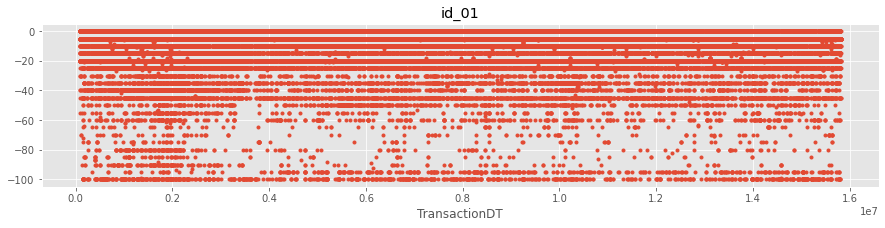

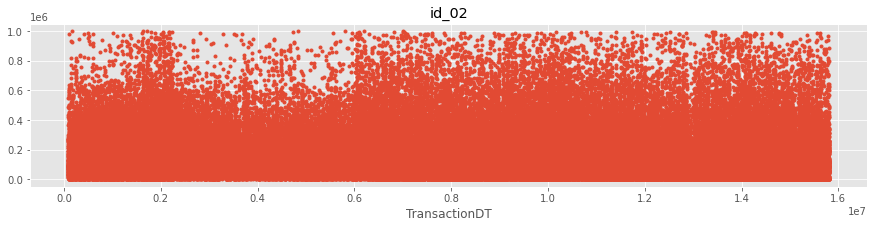

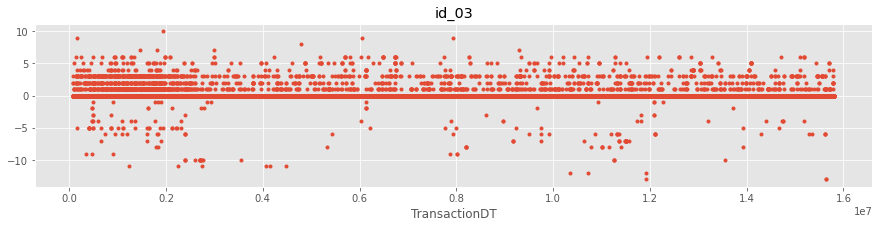

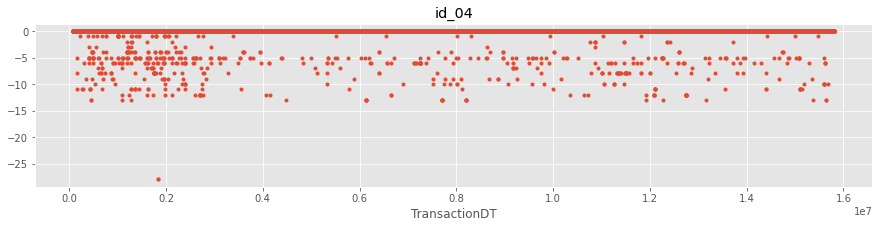

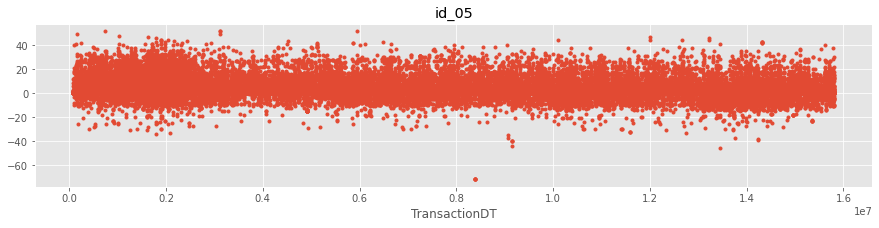

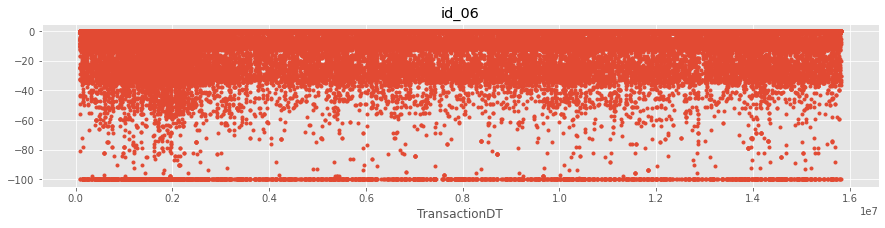

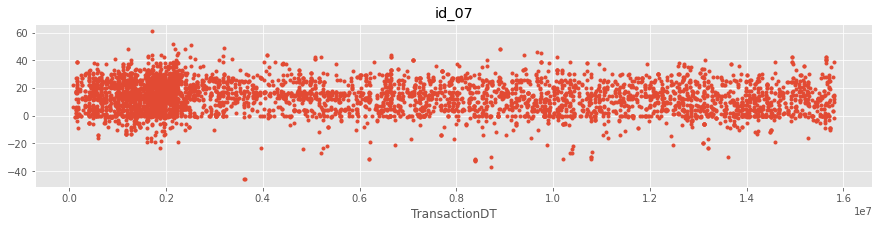

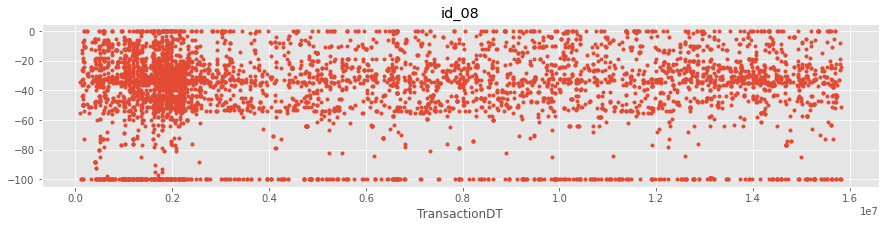

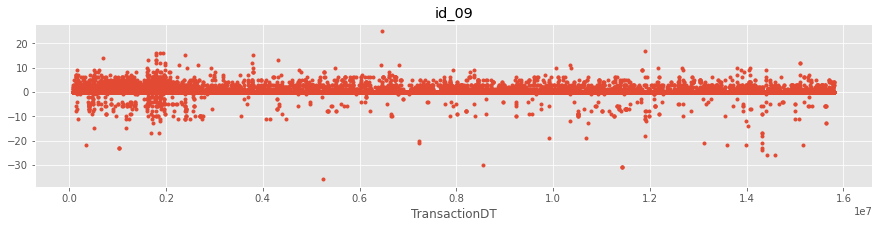

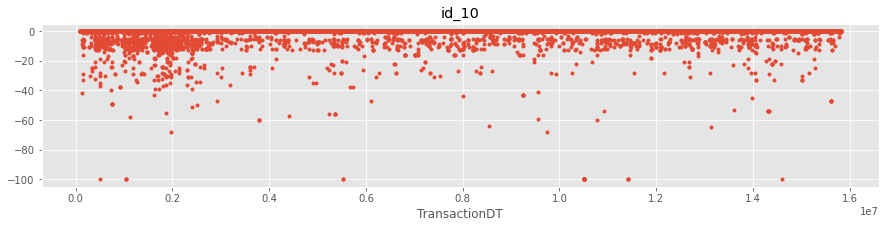

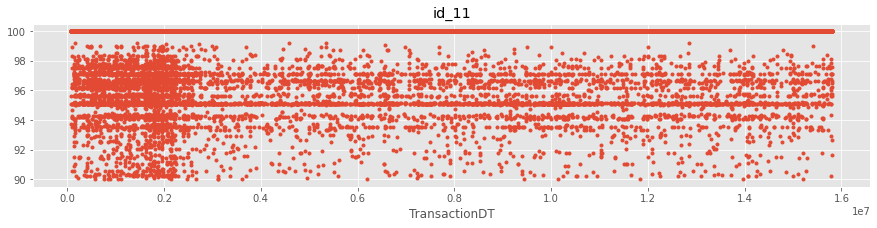

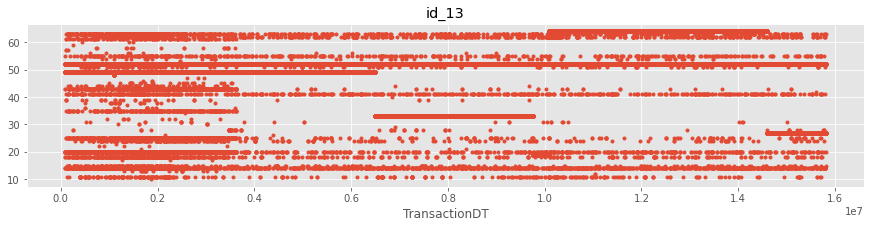

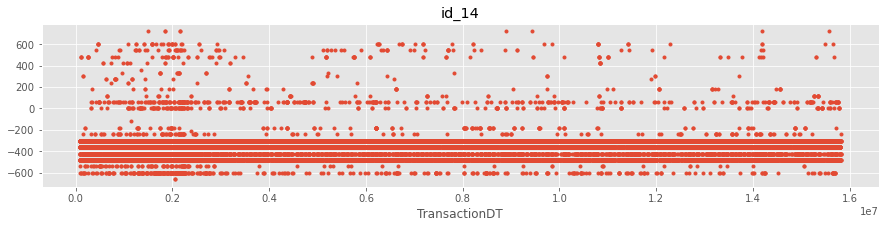

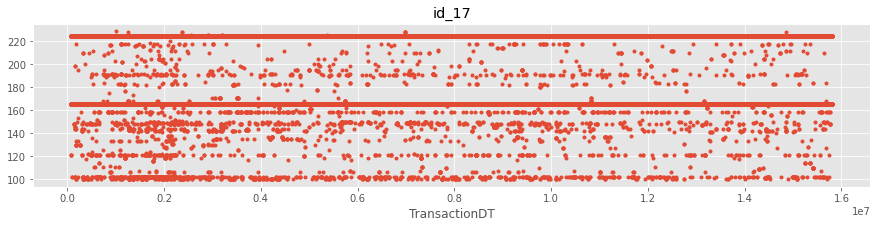

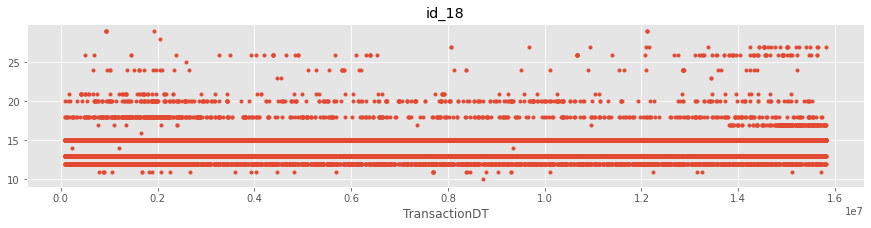

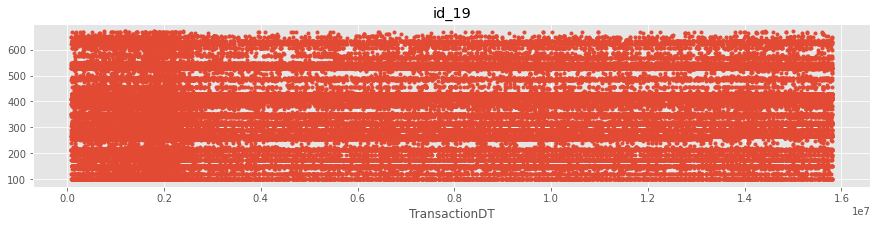

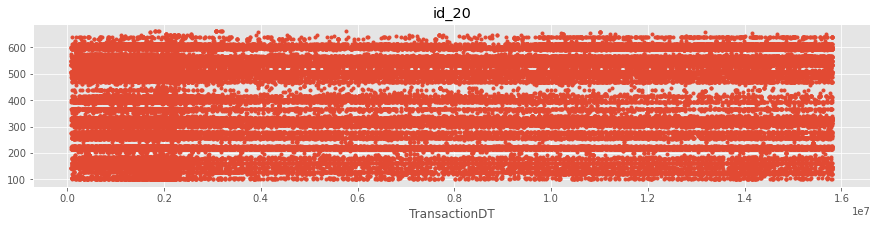

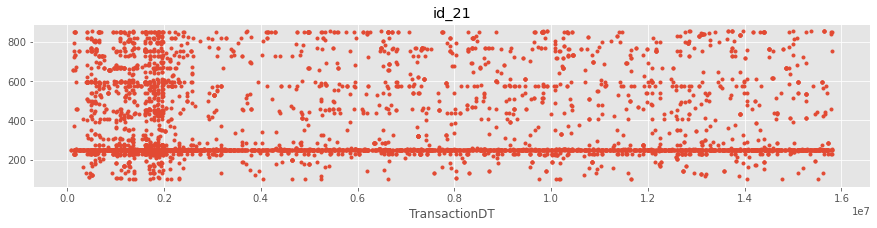

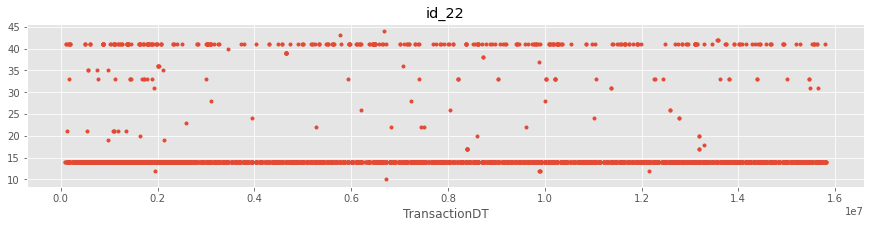

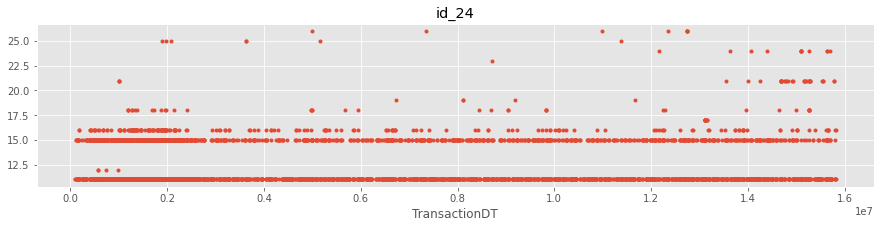

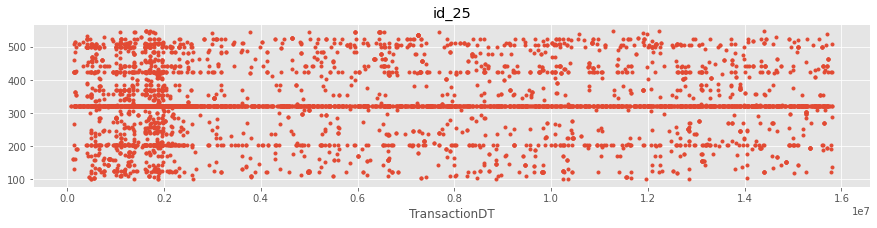

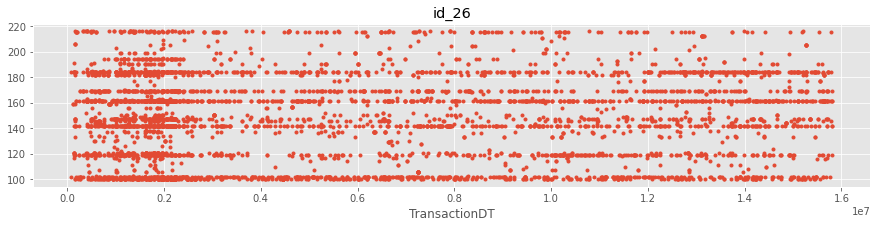

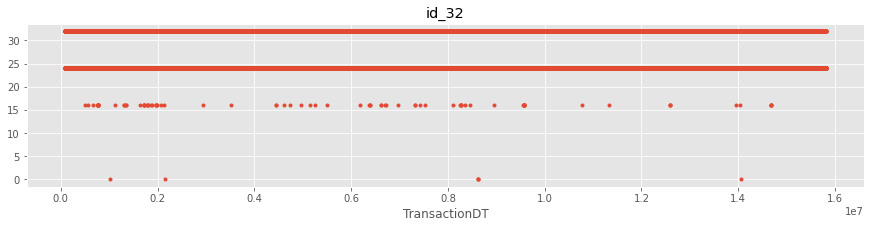

In [134]:
for i in id_cols:
    try:
        train_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        #test_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass

일단 계속 진행

#### 수치형 데이터 비교

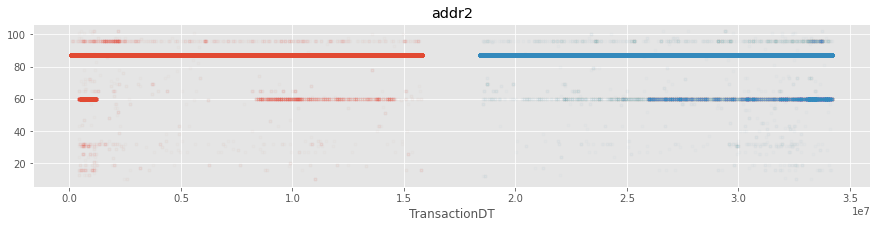

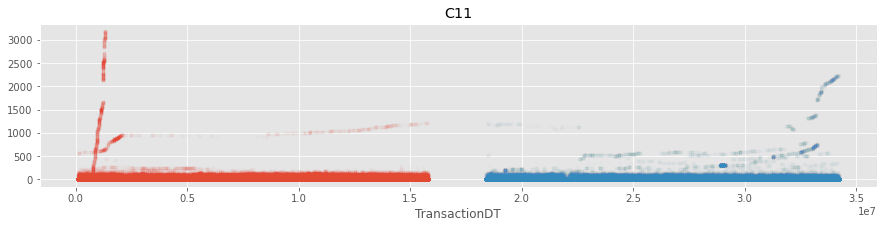

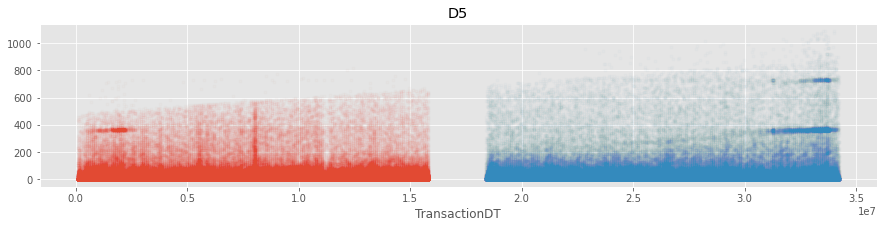

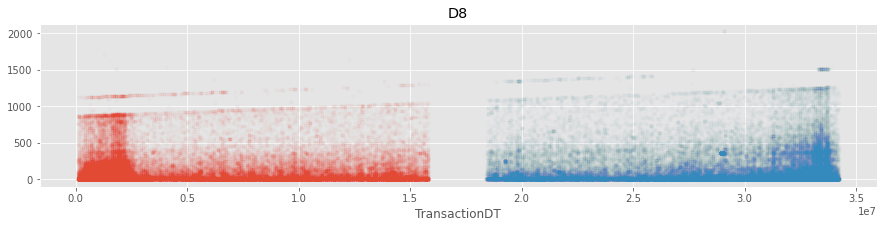

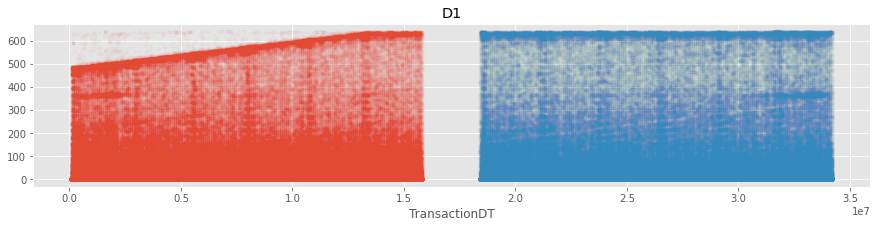

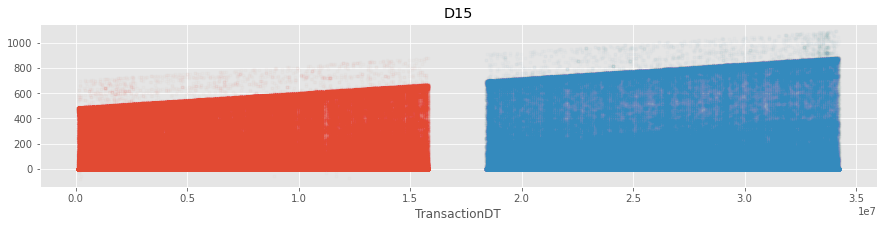

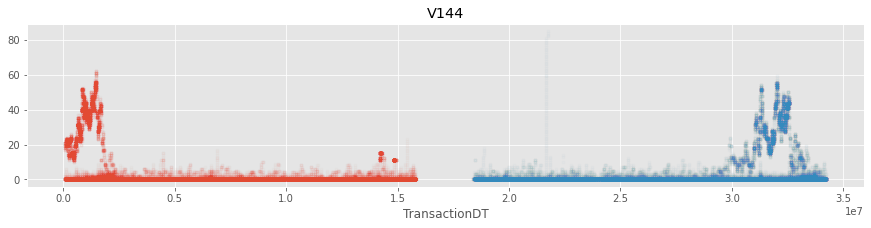

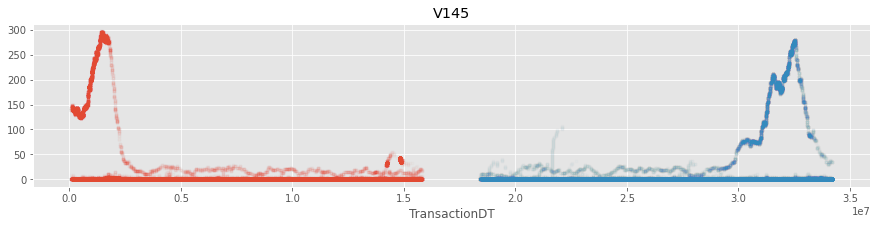

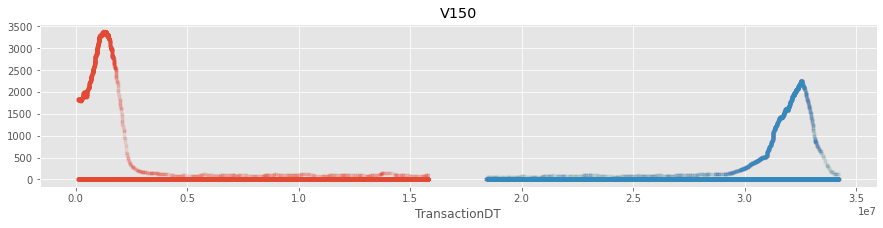

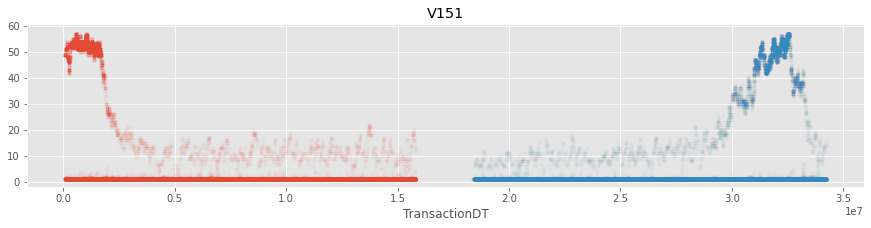

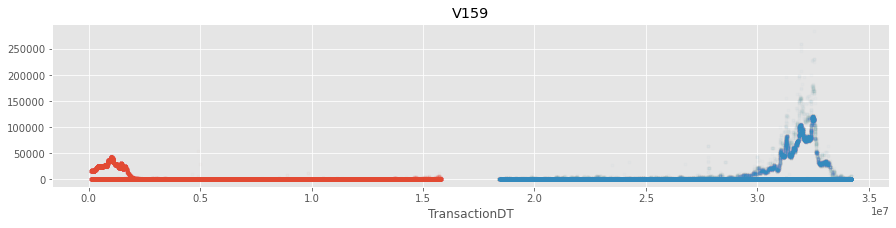

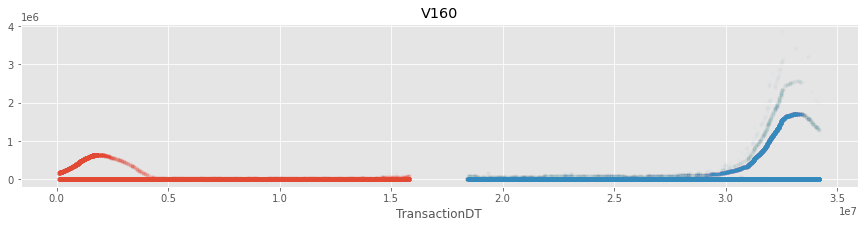

In [141]:
for c in ['addr2','C11','D5','D8','D1','D15','V144','V145','V150','V151','V159','V160']:
    try:
        train_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass